In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import imutils
import glob
from skimage import exposure
from skimage import feature
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def _subImage(image1, string1, image2, string2):
    fix, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image1, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(string1)
    axs[1].imshow(image2, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(string2)
    plt.show()

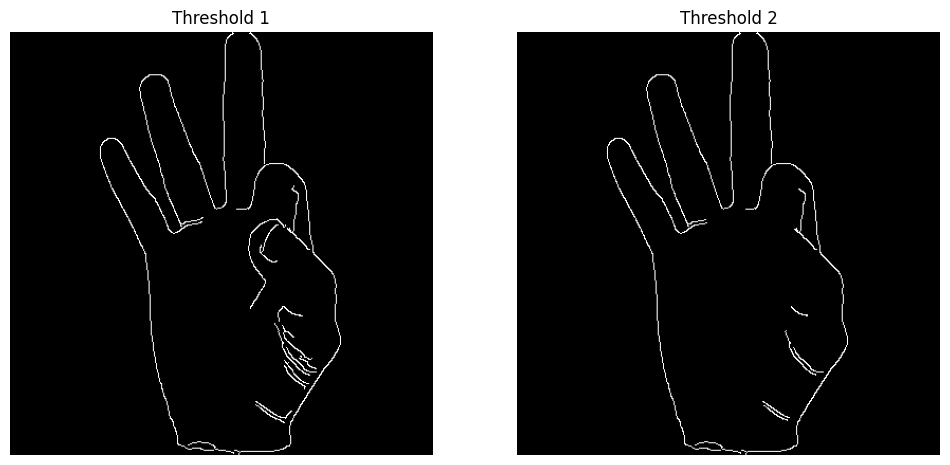

In [3]:
img_path = r'./Dataset/train/9/01.jpeg'
test_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
test_image = cv2.GaussianBlur(test_image, (5,5), 0)
test_image1 = cv2.Canny(test_image, 50, 150)
test_image2 = cv2.Canny(test_image, 70, 210)
_subImage(test_image1, "Threshold 1", test_image2, "Threshold 2")

Rõ ràng là sau khi dịch chuyển độ lớn của ngưỡng Low-High Threshold thì đường biên của tay đã được cải thiện hơn, loại bỏ được nhiều nhiều nhiễu hơn giảm thiểu được các đường biên ngắn. Tuy nhiên cũng sẽ mất điên một số đường biên quan trọng của tay

In [7]:
test_image.shape

(400, 400)

[0. 0. 0. ... 0. 0. 0.]
(54756,)


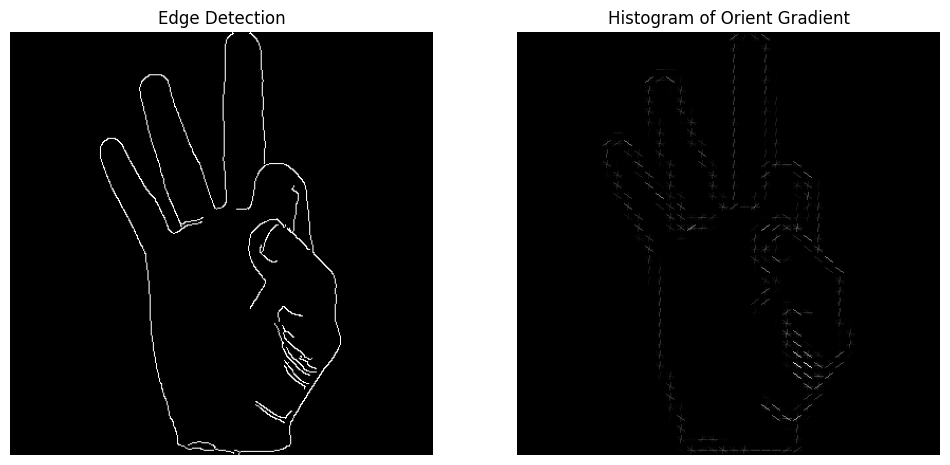

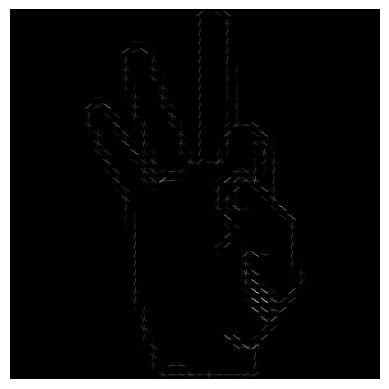

In [6]:
H, hog_image = feature.hog(test_image1, orientations=9, pixels_per_cell=(10, 10),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2", visualize=True)
# hog_image = hog_image.astype("uint32")
print(H)
print(H.shape)
_subImage(test_image1, "Edge Detection", hog_image, "Histogram of Orient Gradient")
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.show()

## Sử dụng HOG để trích xuất đặc trưng ảnh

In [9]:
def _preprocessing(fileType):
    data = []
    labels = []
    for path in glob.glob(fileType):
        _, type, fn = path.split('\\')
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img, (5,5), 0)
        # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edeged = cv2.Canny(img, 50, 150)
        # Khởi tạo HOG descriptor
        H, hog_image = feature.hog(edeged, orientations=9, pixels_per_cell=(10, 10),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2", visualize=True)

        # update the data and labels
        data.append(H)
        labels.append(type)

    return data, labels, H
data, labels, HOG= _preprocessing('./Dataset/train/**/*.jpeg')

In [3]:
print(HOG.shape)
print(HOG)

(54756,)
[0. 0. 0. ... 0. 0. 0.]


In [4]:
def _save(path, obj):
    with open(path, 'wb') as fn:
        pickle.dump(obj, fn)

In [30]:
def _transform_data(data, labels):
    # Tạo input array X
    X = np.array(data, dtype=object)
    # Tạo output array y
    le = LabelEncoder()
    le.fit(labels)
    y = le.transform(labels)
    y_ind = np.unique(y)
    y_dict = dict(zip(y_ind, le.classes_))
    return X, y, y_dict, le

X_train, y_train, y_dict, le = _transform_data(data, labels)
X_train

array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(456, 54756) (114, 54756) (456,) (114,)


In [ ]:
def _subAccuracy(L1, L2):
    fig, ax = plt.subplots()
    table_data = [[L1[i], L2[i]] for i in range(len(L1))]
    table = ax.table(cellText=table_data,
                 colLabels=['L1', 'L2'],
                 rowLabels=['K{}'.format(k) for k in range(1, 11)],
                 cellLoc='center',
                 loc='center')

# Định dạng bảng
    table.scale(1, 1.5)  # Điều chỉnh kích thước chiều rộng và chiều cao của ô
    table.auto_set_font_size(False)  # Tắt tự động điều chỉnh kích thước font
    table.set_fontsize(12)  # Đặt kích thước font chữ

# Tắt trục x và trục y
    ax.axis('off')

# Hiển thị biểu đồ
    plt.show()

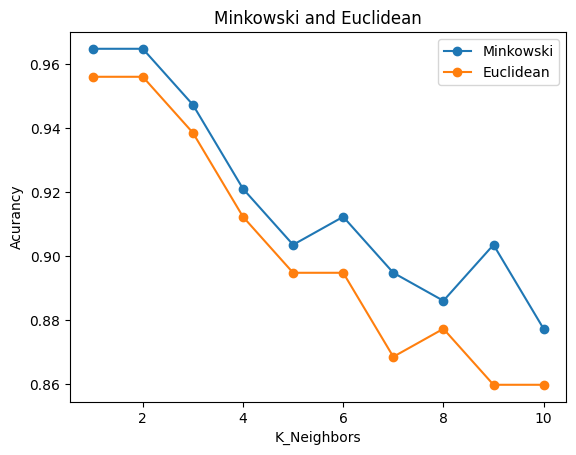

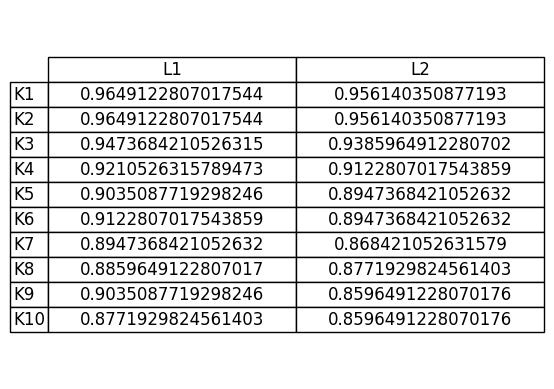

In [37]:
# Giá trị của số lượng neighbors để thử
n_neighbors_list = list(range(1, 11))
result_L1 = []
result_L2 = []
for n_neighbors in n_neighbors_list:
    # Mô hình KNN với distance measure là L1
    model_L1 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=n_neighbors, p=1,
           weights='distance')
    model_L1.fit(X_train, y_train)
    # Dự đoán nhãn lớp trên tập kiểm tra
    y_pred = model_L1.predict(X_test)
    accuracy_L1 = accuracy_score(y_test, y_pred)
    result_L1.append(accuracy_L1)


    # Mô hình KNN với distance measure là L2
    model_L2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=n_neighbors, p=2,
           weights='distance')
    model_L2.fit(X_train, y_train)
    # Dự đoán nhãn lớp trên tập kiểm tra
    y_pred = model_L2.predict(X_test)
    accuracy_L2 = accuracy_score(y_test, y_pred)
    result_L2.append(accuracy_L2)

plt.plot(n_neighbors_list, result_L1, marker='o', label='Minkowski')
plt.plot(n_neighbors_list, result_L2, marker='o', label='Euclidean')
plt.xlabel('K_Neighbors')
plt.ylabel('Acurancy')
plt.title('Minkowski and Euclidean')
plt.legend()
plt.show()

_subAccuracy(result_L1, result_L2)
del result_L1 # Phải xóa đi không run lại nó lại điền tiếp kết quả zô mảng --> kết quả bị sai nha
del result_L2